# ============================================================
# AE3 - Exercicio 3A - Deslocamentos placa bidimensional engastada 2 lados



# Bloco 1 — Importar bibliotecas, parâmetros do problema e hiperparâmetros 
# ========================================================================

In [1]:
# === BLOCO 1 — Imports, dispositivo e utilitários ===
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); np.random.seed(0)

# helper: cria tensor LEAF com grad habilitado
def leaf(x_np_or_torch):
    if isinstance(x_np_or_torch, np.ndarray):
        x = torch.tensor(x_np_or_torch, dtype=torch.float32, device=device)
    else:
        x = x_np_or_torch
    x.requires_grad_(True)
    return x

# derivada escalar y w.r.t. coluna i de x
def d(y, x, i):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
    )[0][:, i:i+1]


# ===========================================================================
# === BLOCO 2 — Parâmetros físicos, domínio e hiperparâmetros ===
# ===========================================================================

In [9]:
# === BLOCO 2 — Parâmetros físicos, domínio e hiperparâmetros ===

# domínio quadrado unitário
L = 1.0

# material (plane stress)
E  = 1.0
nu = 0.3
C11 = E/(1.0 - nu**2)
C12 = nu*C11
G   = E/(2.0*(1.0+nu))

# amostras (colocação)
Nf  = 12000     # interior (PDE)
Nr  = 3000      # x=1 (tração prescrita)
Nt  = 2000      # y=1 (livre)
Nb  = 3000      # y=0 (apoio sem atrito) — usado para reforçar σxy=0 opcionalmente

# rede / treino
HIDDEN_LAYERS   = 4
NEURONS_PER_LAY = 64
ACTIVATION_NAME = "tanh"
LR     = 1e-3
EPOCHS = 10000
USE_LBFGS = True

# pesos da loss
LAMBDA_PDE = 1.0
LAMBDA_R   = 20.0    # x=1: σxx=1 e σxy=0
LAMBDA_T   = 10.0    # y=1: livre σyy=0 e σxy=0
LAMBDA_B   = 10.0    # y=0: opcional σxy=0 (v=0 já é HARD)

print("[Config 3A — PyTorch]")
print(f"  Rede: {HIDDEN_LAYERS} camadas × {NEURONS_PER_LAY} neurônios (ativ={ACTIVATION_NAME})")
print(f"  Pontos: Nf={Nf}, Nr={Nr}, Nt={Nt}, Nb={Nb}")
print(f"  Pesos: PDE={LAMBDA_PDE}, x=1={LAMBDA_R}, y=1={LAMBDA_T}, y=0={LAMBDA_B}")


[Config 3A — PyTorch]
  Rede: 4 camadas × 64 neurônios (ativ=tanh)
  Pontos: Nf=12000, Nr=3000, Nt=2000, Nb=3000
  Pesos: PDE=1.0, x=1=20.0, y=1=10.0, y=0=10.0


## Foi selecionado a Condições de deslocamento Hard pois Garante que as Condições de Contorno de deslocamento sejam respeitadas com erro numérico nulo, melhora a estabilidade do treino e evita competição entre termos da loss.

# ==========================================================================
# Bloco 3 — Amostragem dos pontos (interior e bordas)
# ==========================================================================

In [3]:
# === BLOCO 3 — Amostragem dos pontos (interior e bordas) ===

def _end_cluster(n, width=0.06):
    n2 = n//2
    a = torch.rand(n2,1,device=device)*width
    b = 1.0 - torch.rand(n-n2,1,device=device)*width
    return torch.cat([a,b], dim=0)

def sample_interior(N):
    return leaf(torch.rand(N,2,device=device)*L)

def sample_right(N):          # x=1 com reforço nos cantos y≈0,1
    y = torch.rand(int(0.6*N),1,device=device)*L
    y_edge = _end_cluster(N-int(0.6*N))*L
    y = torch.cat([y, y_edge], dim=0)
    x = torch.full((N,1), L, device=device)
    return leaf(torch.cat([x,y], dim=1))

def sample_top(N):            # y=1 com leve reforço nas extremidades x≈0,1
    x = torch.rand(int(0.7*N),1,device=device)*L
    x_edge = _end_cluster(N-int(0.7*N))*L
    x = torch.cat([x, x_edge], dim=0)
    y = torch.full((N,1), L, device=device)
    return leaf(torch.cat([x,y], dim=1))

def sample_bottom(N):         # y=0 com reforço nas extremidades x≈0,1
    x = torch.rand(int(0.6*N),1,device=device)*L
    x_edge = _end_cluster(N-int(0.6*N))*L
    x = torch.cat([x, x_edge], dim=0)
    y = torch.zeros(N,1,device=device)
    return leaf(torch.cat([x,y], dim=1))

# primeira amostragem
XY_f = sample_interior(Nf)
XY_r = sample_right(Nr)
XY_t = sample_top(Nt)
XY_b = sample_bottom(Nb)


# ====================================================
# BLOCO 4 — Rede (PINN) e ansatz (C.C. hard)
# ====================================================

In [4]:
# === BLOCO 4 — Rede (PINN) e ansatz (C.C. hard) ===

def make_activation(name):
    return {"tanh": nn.Tanh, "relu": nn.ReLU, "silu": nn.SiLU, "gelu": nn.GELU}[name]()

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden, act="tanh"):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(hidden):
            layers += [nn.Linear(last, NEURONS_PER_LAY), make_activation(act)]
            last = NEURONS_PER_LAY
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class PlatePINN(nn.Module):
    """
    Ansatz (hard BC):
        u(x,y) = y * u_hat(x,y)            -> em y=0, u=0 (opcional; aqui usamos, mas não é obrigatório)
        v(x,y) = y * v_hat(x,y)            -> em y=0, v=0 (HARD)
    Mantém livre em y=1; trações impostas por penalização (soft).
    """
    def __init__(self, act="tanh"):
        super().__init__()
        self.core = MLP(2, 2, HIDDEN_LAYERS, act=act)
    def forward(self, xy):
        uhat, vhat = torch.split(self.core(xy), 1, dim=1)
        y = xy[:,1:2]
        u = y * uhat
        v = y * vhat
        return u, v

net = PlatePINN(ACTIVATION_NAME).to(device)
sum_p = sum(p.numel() for p in net.parameters())
print(f"[Rede] parâmetros treináveis: {sum_p:,}")


[Rede] parâmetros treináveis: 12,802


# ==================================================
# BLOCO 5 — Resíduos da PDE, tensões e função de perda
# ==================================================

In [5]:
# === BLOCO 5 — Resíduos da PDE, tensões e função de perda ===

mse = nn.MSELoss()

def stresses(u, v, xy):
    ux = d(u, xy, 0); uy = d(u, xy, 1)
    vx = d(v, xy, 0); vy = d(v, xy, 1)
    exx = ux; eyy = vy; gxy = uy + vx
    sxx = C11*exx + C12*eyy
    syy = C12*exx + C11*eyy
    sxy = G*gxy
    return sxx, sxy, syy

def pde_residuals(xy):
    u, v = net(xy)
    sxx, sxy, syy = stresses(u, v, xy)
    r1 = d(sxx, xy, 0) + d(sxy, xy, 1)   # σxx,x + σxy,y = 0
    r2 = d(sxy, xy, 0) + d(syy, xy, 1)   # σxy,x + σyy,y = 0
    return r1, r2

def loss_func():
    # PDE
    r1, r2 = pde_residuals(XY_f)
    loss_pde = LAMBDA_PDE*(mse(r1, torch.zeros_like(r1)) + mse(r2, torch.zeros_like(r2)))

    # x=1: σxx = 1, σxy = 0
    ur, vr = net(XY_r)
    sxx_r, sxy_r, _ = stresses(ur, vr, XY_r)
    loss_right = LAMBDA_R*(mse(sxx_r, torch.ones_like(sxx_r)) + mse(sxy_r, torch.zeros_like(sxy_r)))

    # y=1: livre -> σyy = 0, σxy = 0
    ut, vt = net(XY_t)
    _, sxy_t, syy_t = stresses(ut, vt, XY_t)
    loss_top = LAMBDA_T*(mse(syy_t, torch.zeros_like(syy_t)) + mse(sxy_t, torch.zeros_like(sxy_t)))

    # y=0: reforço opcional σxy = 0 (v=0 já é HARD)
    ub, vb = net(XY_b)
    _, sxy_b, _ = stresses(ub, vb, XY_b)
    loss_bottom = LAMBDA_B*mse(sxy_b, torch.zeros_like(sxy_b))

    loss_total = loss_pde + loss_right + loss_top + loss_bottom
    return loss_total, loss_pde, loss_right, loss_top, loss_bottom


# === BLOCO 6 — Treino (Adam + L-BFGS) e curva da loss ===

[Treino] Adam
  epoch  1000: loss=2.689e-01 | PDE=1.238e-01 | x=1=6.671e-02 | y=1=3.648e-02 | y=0=4.190e-02
  epoch  2000: loss=9.827e-02 | PDE=3.878e-02 | x=1=1.712e-02 | y=1=2.200e-02 | y=0=2.037e-02
  epoch  3000: loss=8.096e-02 | PDE=3.215e-02 | x=1=1.013e-02 | y=1=2.257e-02 | y=0=1.612e-02
  epoch  4000: loss=6.647e-02 | PDE=2.972e-02 | x=1=8.782e-03 | y=1=1.275e-02 | y=0=1.521e-02
  epoch  5000: loss=6.639e-02 | PDE=1.993e-02 | x=1=1.284e-02 | y=1=2.018e-02 | y=0=1.344e-02
  epoch  6000: loss=6.423e-02 | PDE=2.357e-02 | x=1=5.931e-03 | y=1=2.063e-02 | y=0=1.410e-02
  epoch  7000: loss=7.040e-02 | PDE=3.576e-02 | x=1=1.120e-02 | y=1=9.575e-03 | y=0=1.386e-02
  epoch  8000: loss=4.418e-02 | PDE=1.524e-02 | x=1=9.794e-03 | y=1=7.667e-03 | y=0=1.148e-02
  epoch  9000: loss=4.181e-02 | PDE=1.485e-02 | x=1=6.144e-03 | y=1=8.803e-03 | y=0=1.201e-02
  epoch 10000: loss=4.261e-02 | PDE=1.658e-02 | x=1=9.352e-03 | y=1=5.403e-03 | y=0=1.128e-02
  epoch 11000: loss=4.637e-02 | PDE=2.234e-02 

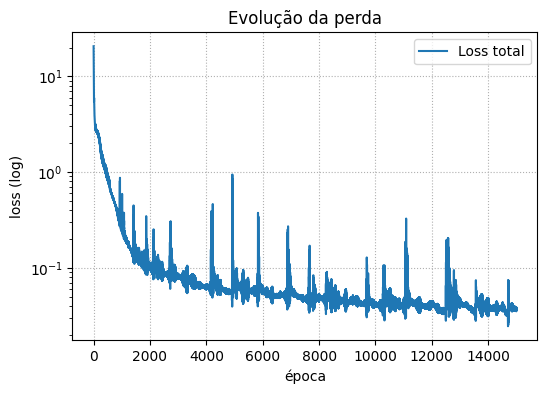

In [6]:
# === BLOCO 6 — Treino (Adam + L-BFGS) e curva da loss ===
opt = torch.optim.Adam(net.parameters(), lr=LR)

loss_hist, pde_hist, right_hist, top_hist, bottom_hist = [], [], [], [], []

print("[Treino] Adam")
for epoch in range(EPOCHS):
    # reamostragem periódica aumenta robustez (e resolve cantos)
    if epoch % 200 == 0:
        XY_f = sample_interior(Nf)
        XY_r = sample_right(Nr)
        XY_t = sample_top(Nt)
        XY_b = sample_bottom(Nb)

    opt.zero_grad()
    lt, lp, lr_, lt_, lb_ = loss_func()
    lt.backward()
    # clipping para estabilidade
    torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    opt.step()

    loss_hist.append(float(lt.detach().cpu()))
    pde_hist.append(float(lp.detach().cpu()))
    right_hist.append(float(lr_.detach().cpu()))
    top_hist.append(float(lt_.detach().cpu()))
    bottom_hist.append(float(lb_.detach().cpu()))

    if (epoch+1) % 1000 == 0:
        print(f"  epoch {epoch+1:5d}: loss={loss_hist[-1]:.3e} | "
              f"PDE={pde_hist[-1]:.3e} | x=1={right_hist[-1]:.3e} | y=1={top_hist[-1]:.3e} | y=0={bottom_hist[-1]:.3e}")

# L-BFGS para refino
if USE_LBFGS:
    print("[Treino] L-BFGS (refino)")
    # reamostra para garantir LEAFs
    XY_f = sample_interior(Nf)
    XY_r = sample_right(Nr)
    XY_t = sample_top(Nt)
    XY_b = sample_bottom(Nb)

    optimizer = torch.optim.LBFGS(net.parameters(), lr=1.0, max_iter=600,
                                  history_size=50, line_search_fn="strong_wolfe")
    def closure():
        optimizer.zero_grad()
        ltot, *_ = loss_func()
        ltot.backward()
        return ltot
    lbfgs_loss = optimizer.step(closure).item()
    print(f"  LBFGS final loss: {lbfgs_loss:.3e}")

# curva da perda
plt.figure(figsize=(6,4))
plt.plot(loss_hist, label="Loss total")
plt.yscale("log"); plt.grid(True, ls=":")
plt.xlabel("época"); plt.ylabel("loss (log)")
plt.legend(); plt.title("Evolução da perda"); plt.show()


# === BLOCO 7 — Pós-processamento: campos e checagem de contorno ===


[Checagem de tração e apoio]
  x=1:  σxx→1   RMS=7.474e-03,  max|err|=3.820e-02
        σxy→0   RMS=8.449e-03,              max|err|=2.227e-02
  y=1:  σyy→0   RMS=3.168e-03,              max|err|=1.085e-02
        σxy→0   RMS=3.027e-03,              max|err|=1.449e-02
  y=0:  v=0(hard) max|v|=0.000e+00          σxy→0  RMS=2.680e-02, max|err|=4.785e-02


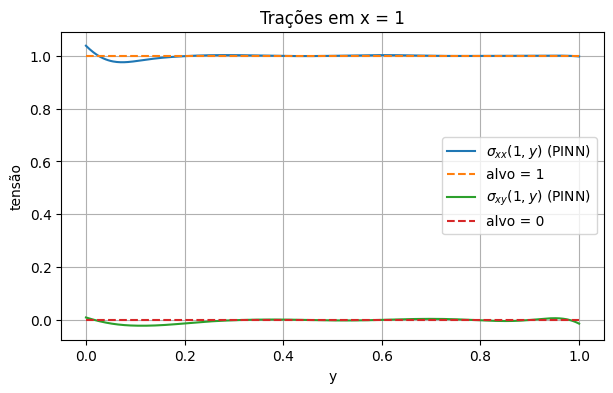

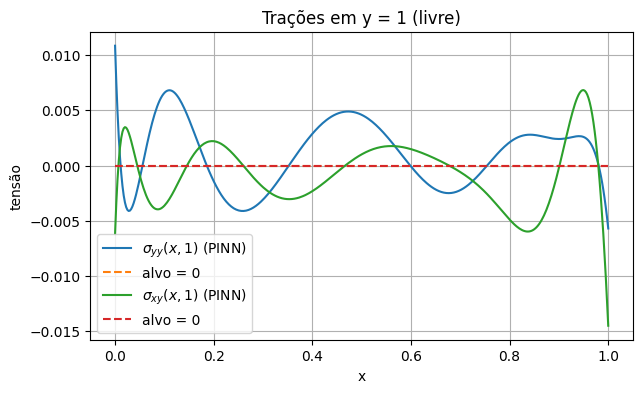

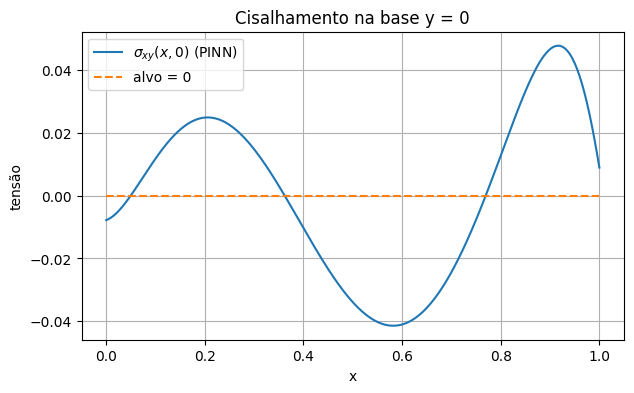

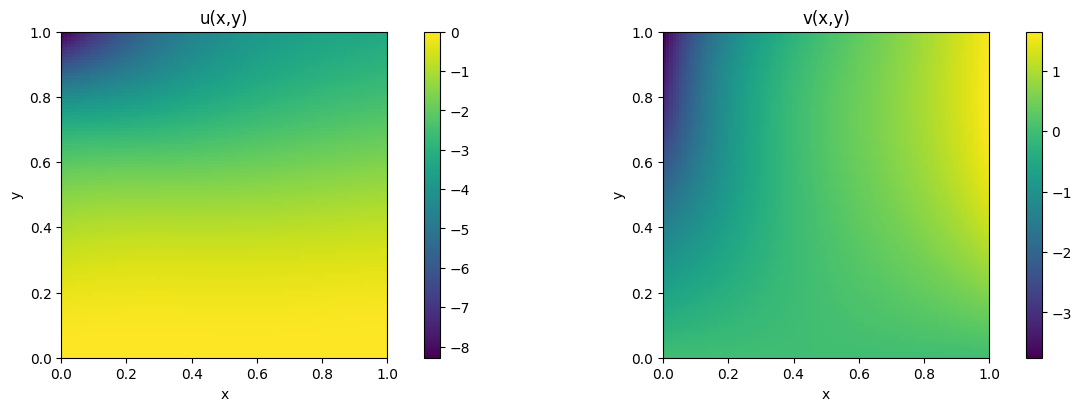

In [7]:
# === BLOCO 7 — Pós-processamento: campos e checagem de contorno ===

# grade para visualizar u,v
Nx = Ny = 101
xg = np.linspace(0, L, Nx); yg = np.linspace(0, L, Ny)
xx, yy = np.meshgrid(xg, yg, indexing="xy")
XYg = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1),
                   dtype=torch.float32, device=device)

with torch.no_grad():
    ug, vg = net(XYg)
U = ug.reshape(Ny, Nx).cpu().numpy()
V = vg.reshape(Ny, Nx).cpu().numpy()

# --- perfis de checagem de tração ---
Ny_chk = 400
y_chk = torch.linspace(0, L, Ny_chk, device=device).view(-1,1)
XY_right = leaf(torch.cat([torch.full_like(y_chk, L), y_chk], dim=1))   # x=1

Nx_chk = 400
x_chk = torch.linspace(0, L, Nx_chk, device=device).view(-1,1)
XY_top  = leaf(torch.cat([x_chk, torch.full_like(x_chk, L)], dim=1))   # y=1
XY_bot  = leaf(torch.cat([x_chk, torch.zeros_like(x_chk)], dim=1))     # y=0

# x = 1
ur, vr = net(XY_right)
sxx_r, sxy_r, _ = stresses(ur, vr, XY_right)
sxx_r = sxx_r.detach().cpu().numpy().ravel()
sxy_r = sxy_r.detach().cpu().numpy().ravel()
target_sxx_r = np.ones_like(sxx_r)

# y = 1
ut, vt = net(XY_top)
_, sxy_t, syy_t = stresses(ut, vt, XY_top)
syy_t = syy_t.detach().cpu().numpy().ravel()
sxy_t = sxy_t.detach().cpu().numpy().ravel()

# y = 0
ub, vb = net(XY_bot)
_, sxy_b, _ = stresses(ub, vb, XY_bot)
sxy_b = sxy_b.detach().cpu().numpy().ravel()
vb_   = vb.detach().cpu().numpy().ravel()

# métricas
def rms(a): return float(np.sqrt(np.mean(a**2)))
def maxabs(a): return float(np.max(np.abs(a)))

print("\n[Checagem de tração e apoio]")
print(f"  x=1:  σxx→1   RMS={rms(sxx_r - target_sxx_r):.3e},  max|err|={maxabs(sxx_r - target_sxx_r):.3e}")
print(f"        σxy→0   RMS={rms(sxy_r):.3e},              max|err|={maxabs(sxy_r):.3e}")
print(f"  y=1:  σyy→0   RMS={rms(syy_t):.3e},              max|err|={maxabs(syy_t):.3e}")
print(f"        σxy→0   RMS={rms(sxy_t):.3e},              max|err|={maxabs(sxy_t):.3e}")
print(f"  y=0:  v=0(hard) max|v|={maxabs(vb_):.3e}          σxy→0  RMS={rms(sxy_b):.3e}, max|err|={maxabs(sxy_b):.3e}")

# gráficos de contorno
plt.figure(figsize=(7,4))
plt.plot(y_chk.cpu().numpy(), sxx_r, label=r"$\sigma_{xx}(1,y)$ (PINN)")
plt.plot(y_chk.cpu().numpy(), target_sxx_r, "--", label="alvo = 1")
plt.plot(y_chk.cpu().numpy(), sxy_r, label=r"$\sigma_{xy}(1,y)$ (PINN)")
plt.plot(y_chk.cpu().numpy(), 0*y_chk.cpu().numpy(), "--", label="alvo = 0")
plt.xlabel("y"); plt.ylabel("tensão"); plt.title("Trações em x = 1")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_chk.cpu().numpy(), syy_t, label=r"$\sigma_{yy}(x,1)$ (PINN)")
plt.plot(x_chk.cpu().numpy(), 0*x_chk.cpu().numpy(), "--", label="alvo = 0")
plt.plot(x_chk.cpu().numpy(), sxy_t, label=r"$\sigma_{xy}(x,1)$ (PINN)")
plt.plot(x_chk.cpu().numpy(), 0*x_chk.cpu().numpy(), "--", label="alvo = 0")
plt.xlabel("x"); plt.ylabel("tensão"); plt.title("Trações em y = 1 (livre)")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_chk.cpu().numpy(), sxy_b, label=r"$\sigma_{xy}(x,0)$ (PINN)")
plt.plot(x_chk.cpu().numpy(), 0*x_chk.cpu().numpy(), "--", label="alvo = 0")
plt.xlabel("x"); plt.ylabel("tensão"); plt.title("Cisalhamento na base y = 0")
plt.grid(True); plt.legend(); plt.show()

# mapas de u e v
fig, axs = plt.subplots(1,2,figsize=(12,4), constrained_layout=True)
im0 = axs[0].imshow(U, extent=[0,L,0,L], origin='lower'); axs[0].set_title("u(x,y)")
im1 = axs[1].imshow(V, extent=[0,L,0,L], origin='lower'); axs[1].set_title("v(x,y)")
for ax in axs: ax.set_xlabel("x"); ax.set_ylabel("y")
plt.colorbar(im0, ax=axs[0]); plt.colorbar(im1, ax=axs[1]); plt.show()
